In [30]:
# Import libraries
import numpy as np
import pandas as pd
import scipy
from scipy import special
from pathlib import Path
import math
import scipy.stats as scs
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic

C = 8          # number of credit states


In [14]:
filename_save_out = 'scen_out'

In [3]:
# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

In [4]:
K

100

In [12]:
Ndriver = len(set(driver))

In [5]:
# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [6]:
rho

array([[1.        , 0.71330043, 0.54867614, ..., 0.52680428, 0.69384599,
        0.43595835],
       [0.71330043, 1.        , 0.27764869, ..., 0.64605875, 0.64742997,
        0.35453859],
       [0.54867614, 0.27764869, 1.        , ..., 0.29504695, 0.49383704,
        0.38201147],
       ...,
       [0.52680428, 0.64605875, 0.29504695, ..., 1.        , 0.60296195,
        0.48291409],
       [0.69384599, 0.64742997, 0.49383704, ..., 0.60296195, 1.        ,
        0.65331578],
       [0.43595835, 0.35453859, 0.38201147, ..., 0.48291409, 0.65331578,
        1.        ]])

In [7]:
# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

In [8]:
# Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

In [9]:
# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

In [15]:
# -------- Insert your code here -------- #
if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios

    # -------- Insert your code here -------- #
    losses_out = np.zeros([Nout,K]) 

    for s in range(1, Nout + 1):
        # -------- Insert your code here -------- #
        y = np.random.normal(0, 1, Ndriver)   
        z = np.random.normal(0, 1, K) 
        for k in range(K):               # for CPs 0-99
            cp_index = int(driver[k])-1  # credit index 0-49
            # compute creditworthiness
            w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
            join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
            future_state_index =  join_boundary.index(w)             # infer future credit state
            losses_out[s-1,k] = exposure[k][future_state_index]            # infer future losses 

        # Calculated out-of-sample losses (100000 x 100)
        # Losses_out (sparse matrix)
        Losses_out = scipy.sparse.csr_matrix(losses_out) 

In [16]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix


In [17]:
# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

In [23]:
# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

for portN in range(2):
    # Compute VaR and CVaR
    portf_loss_out = np.sort(Losses_out @ x0[portN])
    print ('portfolio ' + 
           str(portN+1)+
           " mean loss = {}, standard deviation = {}".format(np.mean(portf_loss_out), np.std(portf_loss_out)))
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #

        VaRout[portN, q] = portf_loss_out[int(math.ceil(Nout * alf)) - 1]
        VaRinN[portN, q] = np.mean(portf_loss_out) + scs.norm.ppf(alf) * np.std(portf_loss_out)
        CVaRout[portN, q] = (1/(Nout*(1-alf))) * ((math.ceil(Nout*alf) - 
                                                   Nout*alf) * 
                                                  VaRout[portN,q] + 
                                                  sum(portf_loss_out[int(math.ceil(Nout * alf)):]))
        CVaRinN[portN, q] = np.mean(portf_loss_out) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * np.std(portf_loss_out)

portfolio 1 mean loss = 6378576.0185802, standard deviation = 8564363.465178823
portfolio 2 mean loss = 6226799.392943349, standard deviation = 6376732.074588974


In [24]:
# Perform 100 trials
N_trials = 100

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

In [25]:
for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [84]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1

    # -------- Insert your code here -------- #
    losses_inMC1 = np.zeros([Nin,K])  


    for s in range(1, np.int32(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        # -------- Insert your code here -------- #
        y = np.random.normal(0, 1, Ndriver) 
        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            # -------- Insert your code here -------- #
            z = np.random.normal(0, 1, K) 
            
            for k in range(K):               # for CPs 0-99
                cp_index = int(driver[k])-1  # credit index 0-49
                # compute creditworthiness
                w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
                join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
                future_state_index =  join_boundary.index(w)             # infer future credit state

                losses_inMC1[s-1,k] = exposure[k][future_state_index]           # infer future losses 

    # Calculate losses for MC1 approximation (5000 x 100)
    Losses_inMC1 = scipy.sparse.csr_matrix(losses_inMC1) 
    # Losses_inMC1


    # Monte Carlo approximation 2

    # -------- Insert your code here -------- #
    losses_inMC2 = np.zeros([Nin,K])


    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        # -------- Insert your code here -------- #
        y = np.random.normal(0, 1, Ndriver)   
        z = np.random.normal(0, 1, K)
        
        for k in range(K):               # for CPs 0-99
            cp_index = int(driver[k])-1  # credit index 0-49
            # compute creditworthiness
            w = beta[k] * np.dot(sqrt_rho,y)[cp_index] + np.sqrt(1 - beta[k]**2) * z[k]
            join_boundary = list(np.sort(np.append(w, CS_Bdry[k])))
            future_state_index =  join_boundary.index(w)             # infer future credit state
            losses_inMC2[s-1,k] = exposure[k][future_state_index]    # infer future losses  

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
    Losses_inMC2 = scipy.sparse.csr_matrix(losses_inMC2)
    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN])
            portf_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN])

            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.mean(portf_loss_inMC1)
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.mean(portf_loss_inMC2)
            sigma_p_MC2 = np.std(portf_loss_inMC2)

            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr - 1] =  (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC1[portN,q][tr - 1] 
                                                              + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))

            VaRinN2[portN, q][tr - 1] =  (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC2[portN,q][tr - 1] 
                                                              + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):])) 

            CVaRinMC1[portN, q][tr - 1] = np.mean(portf_loss_inMC1) + scs.norm.ppf(alf) * np.std(portf_loss_inMC1)
            CVaRinMC2[portN, q][tr - 1] = np.mean(portf_loss_inMC2) + scs.norm.ppf(alf) * np.std(portf_loss_inMC2) 
            CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                                       / (1 - alf)) * np.std(portf_loss_inMC1)
            CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                                       / (1 - alf)) * np.std(portf_loss_inMC2)

In [93]:
for tr in range(1, N_trials + 1):
    # Monte Carlo approximation 1
    y_inMC1 = np.zeros((int(np.ceil(Nin / Ns)),Ndriver))
    Losses_inMC1 = np.zeros((Nin,K))

    for s in range(1, int(np.ceil(Nin / Ns) + 1)): # systemic scenarios
        nr_vec = np.random.randn(Ndriver,1)
        y_inMC1[s-1,:] = np.dot(sqrt_rho,nr_vec).T

        for si in range(1, Ns + 1): # idiosyncratic scenarios for each systemic
            z_inMC1 = np.random.randn(K,1)

    # Calculate losses for MC1 approximation (5000 x 100)
    # Losses_inMC1
            for k in range(1,K+1):
                credit_driver = int(driver[k-1])
                if credit_driver != 50:
                    w_inMC1 = beta[k-1] * y_inMC1[s-1,credit_driver] + np.sqrt(1 - beta[k-1]**2) * z_inMC1[k-1]
                buffer_inMC1 = sorted(np.append(w_inMC1,CS_Bdry[k-1,:]))
                cs_index = np.argwhere(buffer_inMC1==w_inMC1)
                Losses_inMC1[5*(s-1)+si-1,k-1] = exposure[k-1,cs_index]

    # Monte Carlo approximation 2
    y_inMC2 = np.zeros((Nin,Ndriver))
    Losses_inMC2 = np.zeros((Nin,K))

    for s in range(1, Nin + 1): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        nr_vec = np.random.randn(Ndriver,1)
        y_inMC2[s-1,:] = np.dot(sqrt_rho,nr_vec).T
        z_inMC2 = np.random.randn(K,1)

    # Calculated losses for MC2 approximation (5000 x 100)
    # Losses_inMC2
        for k in range(1,K+1):
            credit_driver = int(driver[k-1])
            if credit_driver != 50:
                w_inMC2 = beta[k-1] * y_inMC2[s-1,credit_driver] + np.sqrt(1 - beta[k-1]**2) * z_inMC2[k-1]
            buffer_inMC2 = sorted(np.append(w_inMC2,CS_Bdry[k-1,:]))
            cs_index = np.argwhere(buffer_inMC2==w_inMC2)
            Losses_inMC2[s-1,k-1] = exposure[k-1,cs_index]

    # Compute VaR and CVaR

    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            # -------- Insert your code here -------- #
            # Compute portfolio loss
            portf_loss_inMC1 = sorted(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2 = sorted(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            # Compute VaR and CVaR for the current trial
            mu_p_MC1 = np.dot(mu_MC1,x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1)
            mu_p_MC2 = np.dot(mu_MC2,x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2)
            VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) -1]
            VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) -1]
            VaRinN1[portN, q][tr - 1] =  mu_p_MC1 + scs.norm.ppf(alf) * sigma_p_MC1
            VaRinN2[portN, q][tr - 1] =  mu_p_MC2 + scs.norm.ppf(alf) * sigma_p_MC2
            CVaRinMC1[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC1[portN,q][tr - 1] + sum(portf_loss_inMC1[int(math.ceil(Nin*alf)):]))
            CVaRinMC2[portN, q][tr - 1] = (1 / (Nin*(1-alf))) * ((math.ceil(Nin*alf)-Nin*alf) * VaRinMC2[portN,q][tr - 1] + sum(portf_loss_inMC2[int(math.ceil(Nin*alf)):]))
            CVaRinN1[portN, q][tr - 1] = mu_p_MC1 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr - 1] = mu_p_MC2 + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 -alf)) * sigma_p_MC2

In [27]:
# Compute VaR and CVaR

for portN in range(2):
    for q in range(alphas.size):
        alf = alphas[q]
        # -------- Insert your code here -------- #
        # Compute portfolio loss
        portf_loss_inMC1 = np.sort(Losses_inMC1 @ x0[portN])
        portf_loss_inMC2 = np.sort(Losses_inMC2 @ x0[portN])
        
        mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
        var_MC1 = np.cov(Losses_inMC1.toarray(), rowvar=False)
        mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
        var_MC2 = np.cov(Losses_inMC2.toarray(), rowvar=False)
        # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
        # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
        # Compute VaR and CVaR for the current trial
        mu_p_MC1 = np.mean(portf_loss_inMC1)
        sigma_p_MC1 = np.std(portf_loss_inMC1)
        mu_p_MC2 = np.mean(portf_loss_inMC2)
        sigma_p_MC2 = np.std(portf_loss_inMC2)
        
        VaRinMC1[portN, q][tr - 1] = portf_loss_inMC1[int(math.ceil(Nin * alf)) - 1]
        VaRinMC2[portN, q][tr - 1] = portf_loss_inMC2[int(math.ceil(Nin * alf)) - 1]
        VaRinN1[portN, q][tr - 1] =  (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC1[portN,q][tr - 1] 
                                                          + sum(portf_loss_inMC1[int(math.ceil(Nin * alf)):]))

        VaRinN2[portN, q][tr - 1] =  (1/(Nin*(1-alf))) * ((math.ceil(Nin*alf) - Nin*alf) * VaRinMC2[portN,q][tr - 1] 
                                                          + sum(portf_loss_inMC2[int(math.ceil(Nin * alf)):])) 

        CVaRinMC1[portN, q][tr - 1] = np.mean(portf_loss_inMC1) + scs.norm.ppf(alf) * np.std(portf_loss_inMC1)
        CVaRinMC2[portN, q][tr - 1] = np.mean(portf_loss_inMC2) + scs.norm.ppf(alf) * np.std(portf_loss_inMC2) 
        CVaRinN1[portN, q][tr - 1] =  np.mean(portf_loss_inMC1) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                                   / (1 - alf)) * np.std(portf_loss_inMC1)
        CVaRinN2[portN, q][tr - 1] =  np.mean(portf_loss_inMC2) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                                   / (1 - alf)) * np.std(portf_loss_inMC2)

In [94]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37664914.66, CVaR 99.0% = $44799263.74
In-sample MC1: VaR 99.0% = $38224212.77, CVaR 99.0% = $46332924.56
In-sample MC2: VaR 99.0% = $38134223.41, CVaR 99.0% = $46054429.71
In-sample No: VaR 99.0% = $26302264.76, CVaR 99.0% = $29204439.31
In-sample N1: VaR 99.0% = $26649447.72, CVaR 99.0% = $29602735.80
In-sample N2: VaR 99.0% = $26601526.73, CVaR 99.0% = $29550072.77

Out-of-sample: VaR 99.9% = $54239710.40, CVaR 99.9% = $61918108.50
In-sample MC1: VaR 99.9% = $56597390.48, CVaR 99.9% = $64076721.13
In-sample MC2: VaR 99.9% = $55717950.30, CVaR 99.9% = $63735709.67
In-sample No: VaR 99.9% = $32844448.68, CVaR 99.9% = $35215559.26
In-sample N1: VaR 99.9% = $33306853.54, CVaR 99.9% = $35719724.46
In-sample N2: VaR 99.9% = $33248242.88, CVaR 99.9% = $35657239.50


Portfolio 2:

Out-of-sample: VaR 99.0% = $27377484.29, CVaR 99.0% = $33467899.73
In-sample MC1: VaR 99.0% = $27757277.48, CVaR 99.0% = $33706541.31
In-sample MC2: VaR 99.0% = $27512906

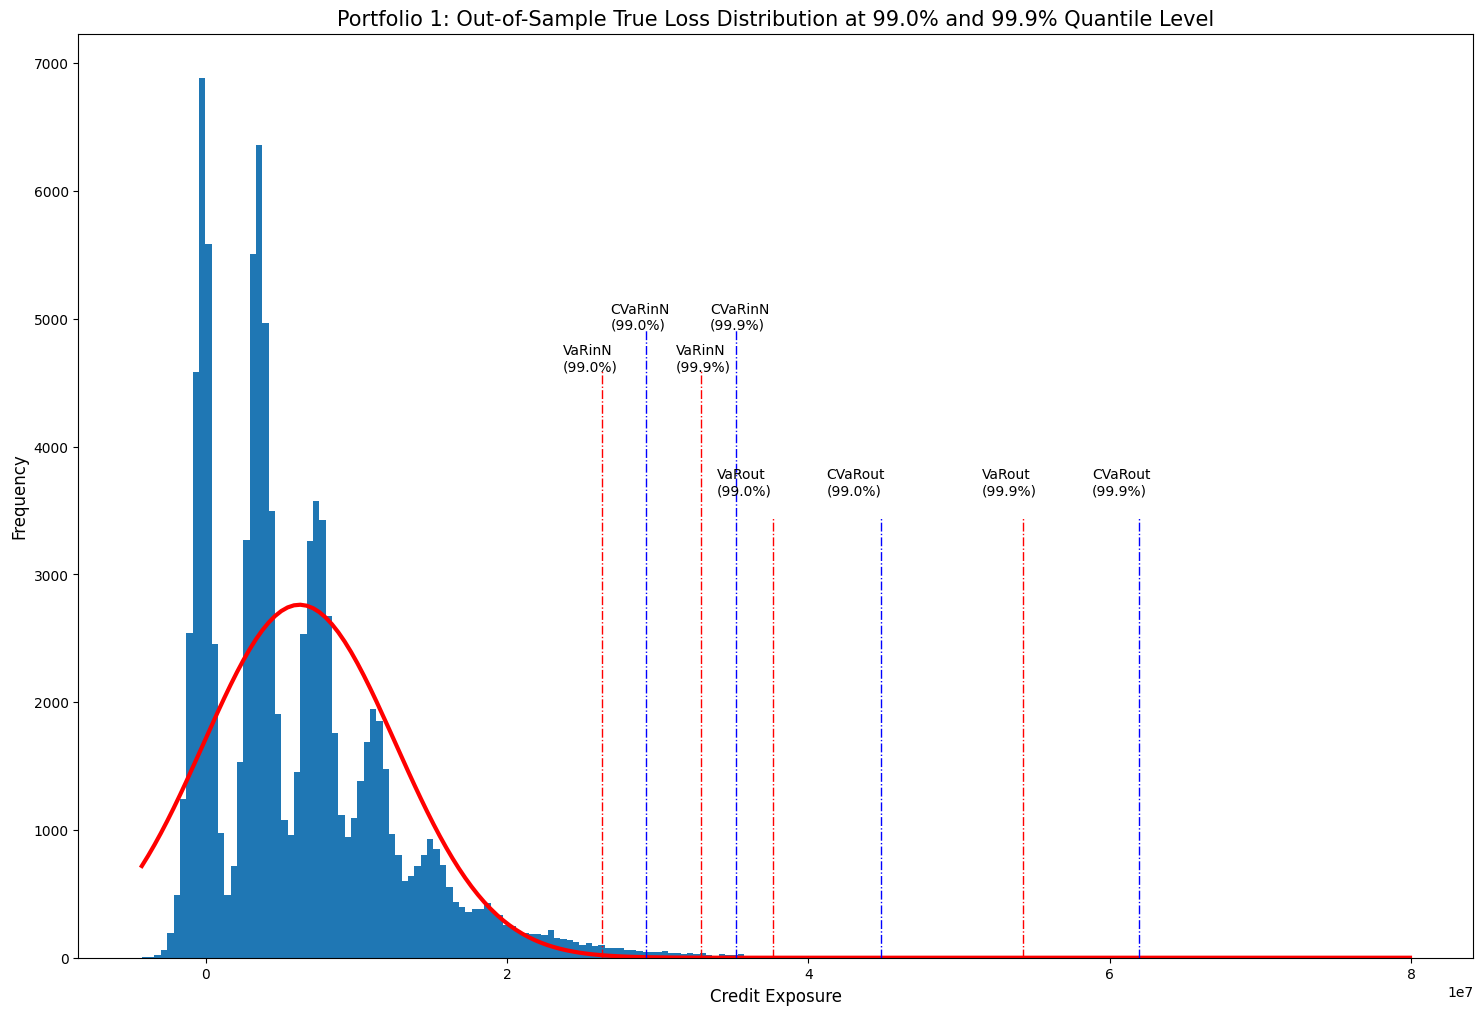

In [123]:

# Plot results
# Figure (1):
# -------- Insert your code here -------- #
# out of sample port lost distribution for port 1, N =100,000
plt.figure(figsize=(18,12))
a = Losses_out @ x0[portN] # portfolio loss
frequencyCounts, binLocations, patches = plt.hist(a, 200)
normf = (1 / (np.std(a) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(a)) / np.std(a)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)


# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[0,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[0,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[0,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[0,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[0,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[0,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[0,1], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.9%)')

plt.title('Portfolio 1: Out-of-Sample True Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p1_out.png')

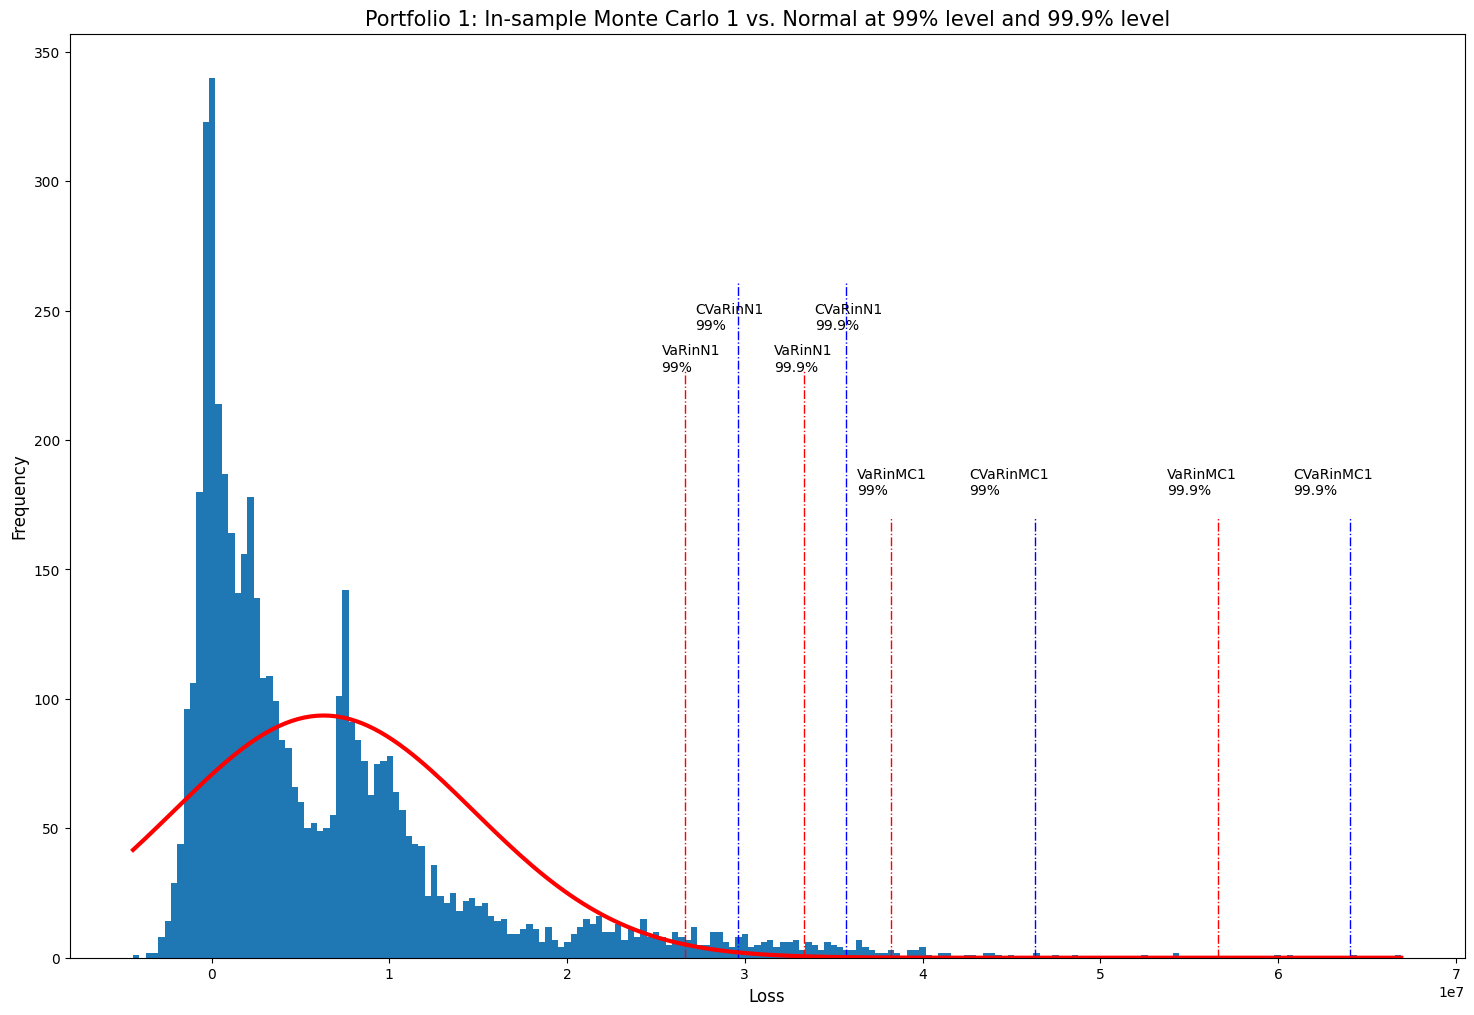

In [144]:
# In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level
plt.figure(figsize=(18,12))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC1[0, 0]), np.mean(VaRinMC1[0, 0])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[0, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[0, 1]), np.mean(VaRinMC1[0, 1])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[0, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[0, 0]), np.mean(CVaRinMC1[0, 0])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC1[0, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[0, 1]), np.mean(CVaRinMC1[0, 1])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC1[0, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN1[0, 0]), np.mean(VaRinN1[0, 0])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[0, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[0, 1]), np.mean(VaRinN1[0, 1])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[0, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[0, 0]), np.mean(CVaRinN1[0, 0])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN1[0, 0]), max(f_count) / 1.4, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[0, 1]), np.mean(CVaRinN1[0, 1])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN1[0, 1]), max(f_count) / 1.4, 'CVaRinN1\n99.9%')

plt.plot(bins, f_n, color = 'r', linewidth=3)
plt.title('Portfolio 1: In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level', fontsize = 15)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('p1_mc1.png')
plt.show()

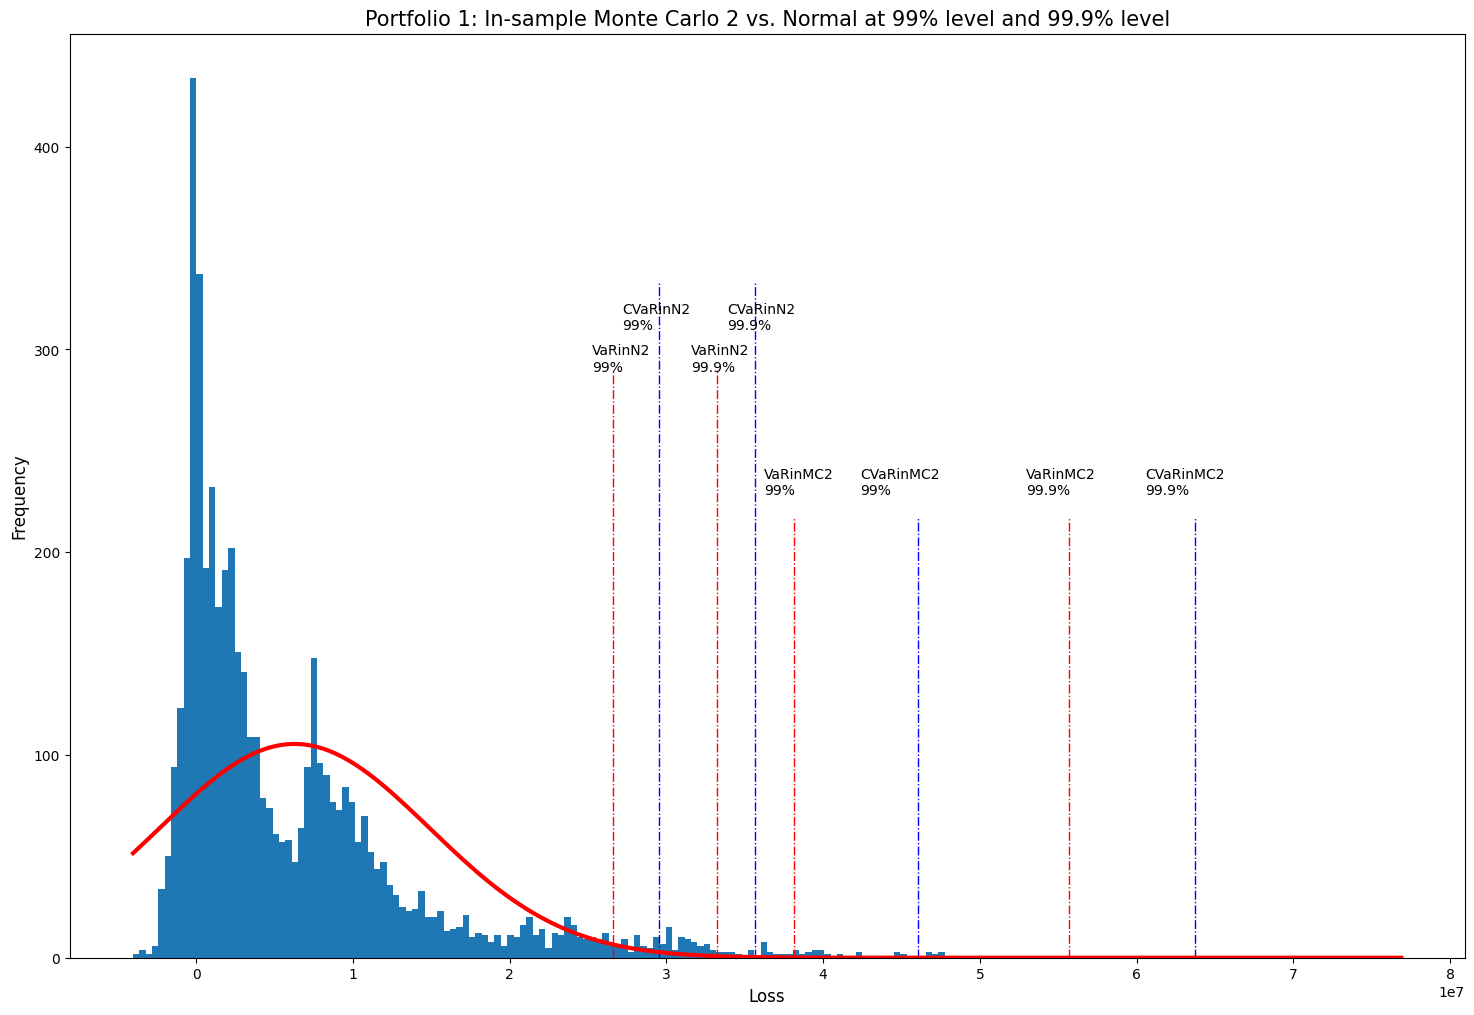

In [143]:
# In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level
plt.figure(figsize=(18,12))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC2[0, 0]), np.mean(VaRinMC2[0, 0])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[0, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[0, 1]), np.mean(VaRinMC2[0, 1])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[0, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[0, 0]), np.mean(CVaRinMC2[0, 0])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC2[0, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[0, 1]), np.mean(CVaRinMC2[0, 1])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC2[0, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN2[0, 0]), np.mean(VaRinN2[0, 0])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[0, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[0, 1]), np.mean(VaRinN2[0, 1])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[0, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[0, 0]), np.mean(CVaRinN2[0, 0])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN2[0, 0]), max(f_count) / 1.4, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[0, 1]), np.mean(CVaRinN2[0, 1])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN2[0, 1]), max(f_count) / 1.4, 'CVaRinN2\n99.9%')

plt.plot(bins, f_n, color = 'r', linewidth=3)
plt.title('Portfolio 1: In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level', fontsize = 15)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('p1_mc2.png')
plt.show()

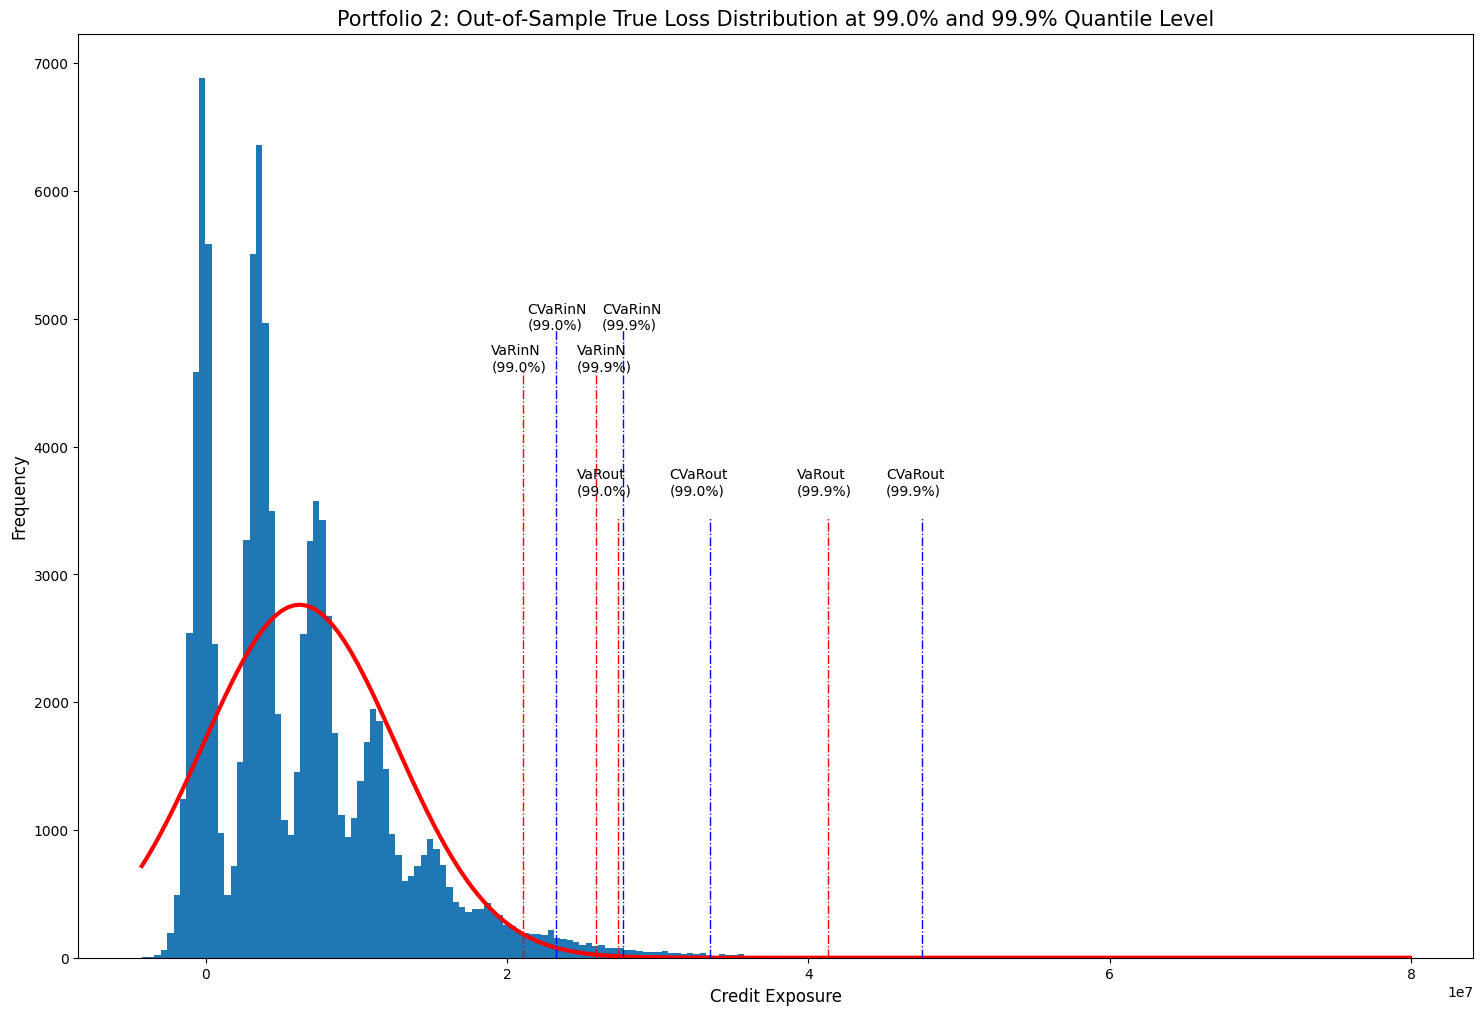

In [139]:
# Out-of-sample vs. Normal at 99% level and 99.9% level
plt.figure(figsize=(18,12))
a = Losses_out @ x0[portN] # portfolio loss
frequencyCounts, binLocations, patches = plt.hist(a, 200)
normf = (1 / (np.std(a) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(a)) / np.std(a)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=3.0)


# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[1,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[1,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[1,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[1,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[1,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/1.4], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[1,1], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.9%)')

plt.title('Portfolio 2: Out-of-Sample True Loss Distribution at 99.0% and 99.9% Quantile Level', fontsize=15)
plt.xlabel('Credit Exposure', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12);
plt.savefig('p2_out.png')

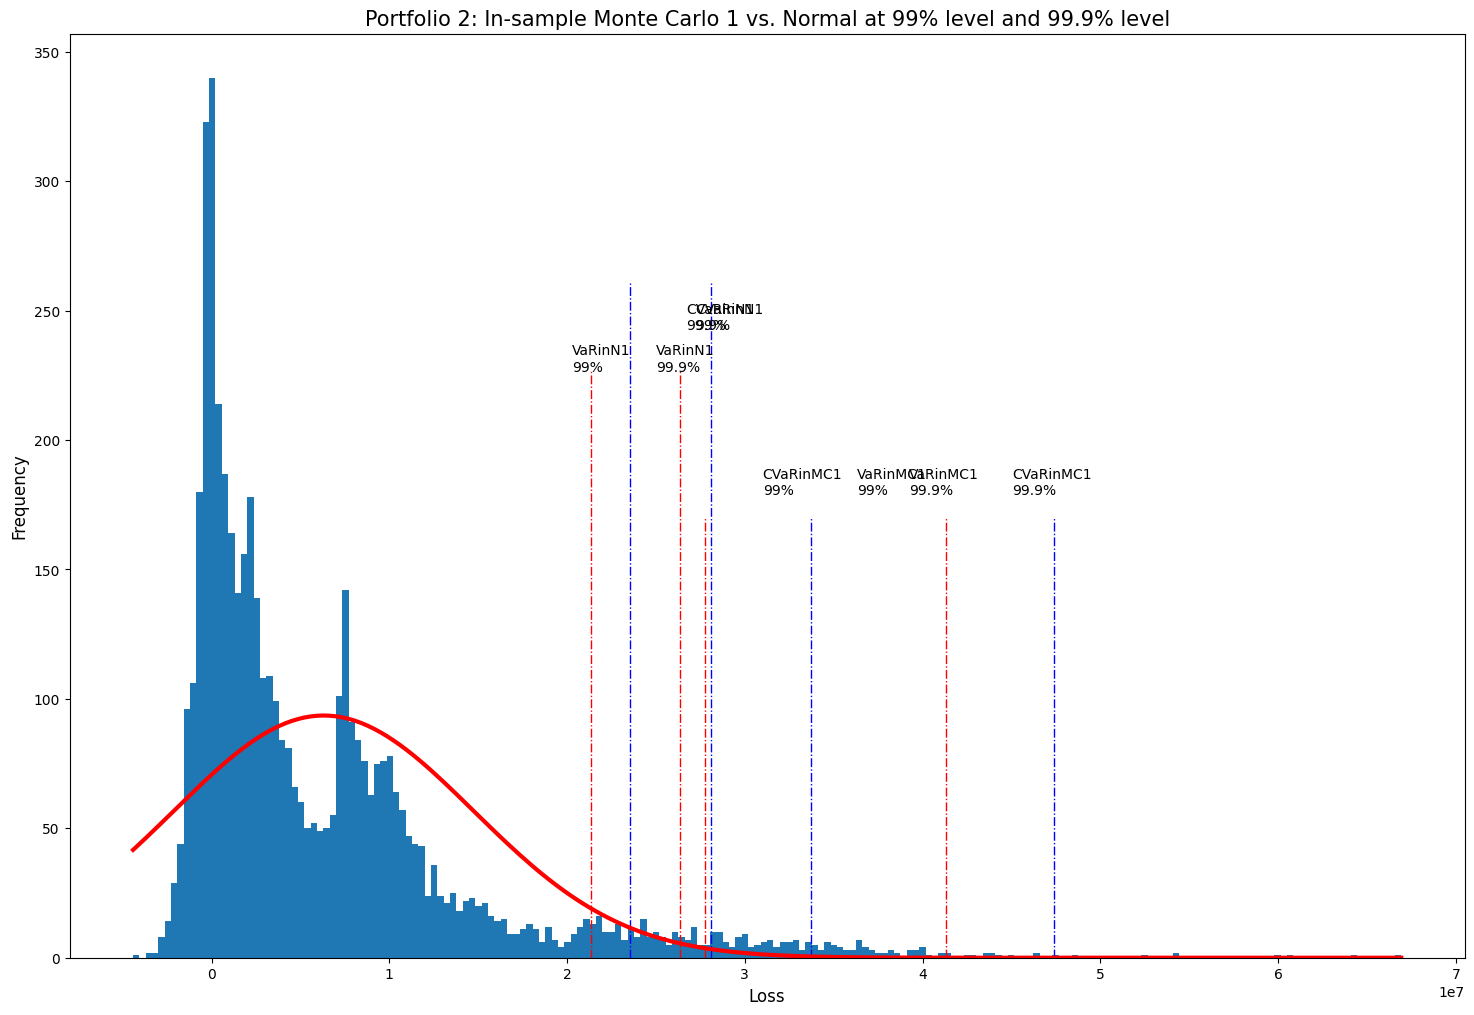

In [142]:
# In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level
plt.figure(figsize=(18,12))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC1,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC1,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC1,x0[0]))) / np.std(np.dot(Losses_inMC1,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC1[1, 0]), np.mean(VaRinMC1[1, 0])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[0, 0]), max(f_count) / 1.9, 'VaRinMC1\n99%')
plt.plot([np.mean(VaRinMC1[1, 1]), np.mean(VaRinMC1[1, 1])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC1[1, 1]), max(f_count) / 1.9, 'VaRinMC1\n99.9%')
plt.plot([np.mean(CVaRinMC1[1, 0]), np.mean(CVaRinMC1[1, 0])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC1[1, 0]), max(f_count) / 1.9, 'CVaRinMC1\n99%')
plt.plot([np.mean(CVaRinMC1[1, 1]), np.mean(CVaRinMC1[1, 1])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC1[1, 1]), max(f_count) / 1.9, 'CVaRinMC1\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN1[1, 0]), np.mean(VaRinN1[1, 0])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[1, 0]), max(f_count) / 1.5, 'VaRinN1\n99%')
plt.plot([np.mean(VaRinN1[1, 1]), np.mean(VaRinN1[1, 1])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN1[1, 1]), max(f_count) / 1.5, 'VaRinN1\n99.9%')
plt.plot([np.mean(CVaRinN1[1, 0]), np.mean(CVaRinN1[1, 0])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN1[0, 0]), max(f_count) / 1.4, 'CVaRinN1\n99%')
plt.plot([np.mean(CVaRinN1[1, 1]), np.mean(CVaRinN1[1, 1])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN1[1, 1]), max(f_count) / 1.4, 'CVaRinN1\n99.9%')

plt.plot(bins, f_n, color = 'r', linewidth=3)
plt.title('Portfolio 2: In-sample Monte Carlo 1 vs. Normal at 99% level and 99.9% level', fontsize = 15)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('p2_mc1.png')
plt.show()

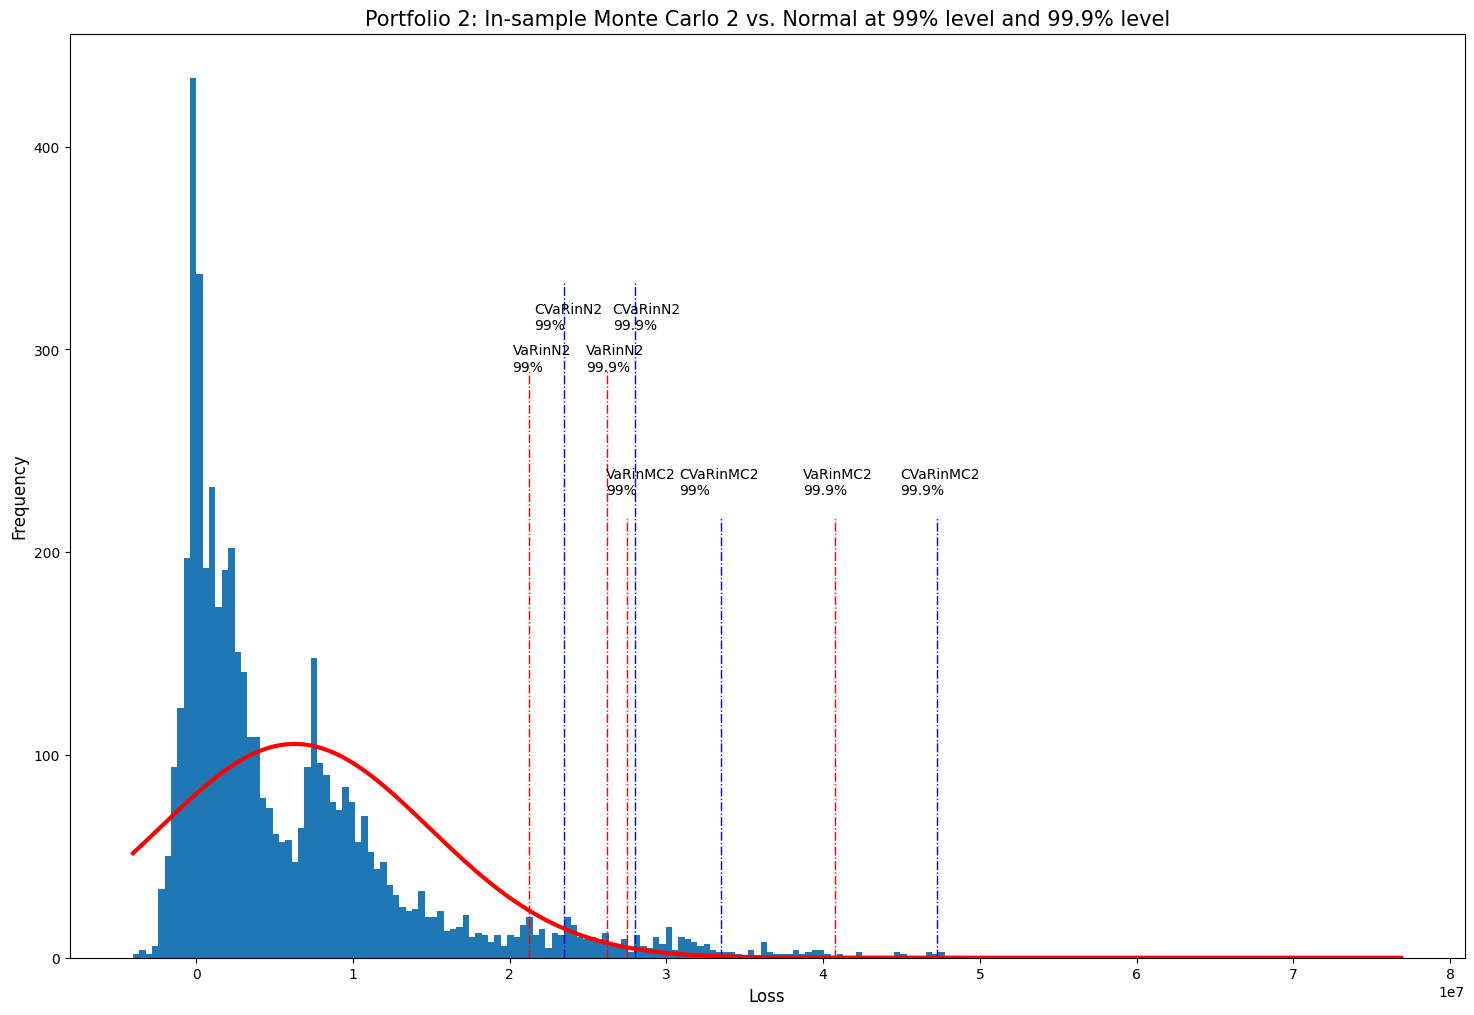

In [148]:
# In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level
plt.figure(figsize=(18,12))
f_count, bins, patch = plt.hist(np.dot(Losses_inMC2,x0[0]), 200)
f_n = (1 / (np.std(np.dot(Losses_inMC2,x0[0])) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((bins-np.mean(np.dot(Losses_inMC2,x0[0]))) / np.std(np.dot(Losses_inMC2,x0[0]))) ** 2)
f_n = f_n * sum(f_count) / sum(f_n)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinMC2[1, 0]), np.mean(VaRinMC2[1, 0])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[1, 0]), max(f_count) / 1.9, 'VaRinMC2\n99%')
plt.plot([np.mean(VaRinMC2[1, 1]), np.mean(VaRinMC2[1, 1])], [0, max(f_count)/2], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinMC2[1, 1]), max(f_count) / 1.9, 'VaRinMC2\n99.9%')
plt.plot([np.mean(CVaRinMC2[1, 0]), np.mean(CVaRinMC2[1, 0])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinMC2[1, 0]), max(f_count) / 1.9, 'CVaRinMC2\n99%')
plt.plot([np.mean(CVaRinMC2[1, 1]), np.mean(CVaRinMC2[1, 1])], [0, max(f_count)/2], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinMC2[1, 1]), max(f_count) / 1.9, 'CVaRinMC2\n99.9%')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([np.mean(VaRinN2[1, 0]), np.mean(VaRinN2[1, 0])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[1, 0]), max(f_count) / 1.5, 'VaRinN2\n99%')
plt.plot([np.mean(VaRinN2[1, 1]), np.mean(VaRinN2[1, 1])], [0, max(f_count)/1.5], color='r', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(VaRinN2[1, 1]), max(f_count) / 1.5, 'VaRinN2\n99.9%')
plt.plot([np.mean(CVaRinN2[1, 0]), np.mean(CVaRinN2[1, 0])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.92 * np.mean(CVaRinN2[1, 0]), max(f_count) / 1.4, 'CVaRinN2\n99%')
plt.plot([np.mean(CVaRinN2[1, 1]), np.mean(CVaRinN2[1, 1])], [0, max(f_count)/1.3], color='b', linewidth=1, linestyle='-.')
plt.text(0.95 * np.mean(CVaRinN2[1, 1]), max(f_count) / 1.4, 'CVaRinN2\n99.9%')

plt.plot(bins, f_n, color = 'r', linewidth=3)
plt.title('Portfolio 2: In-sample Monte Carlo 2 vs. Normal at 99% level and 99.9% level', fontsize = 15)
plt.xlabel('Loss', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.savefig('p2_mc2.png')
plt.show()

In [155]:
# Sampling error for portfolio 1
se_p1_Va99_mc1 = abs(np.mean(VaRinMC1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
se_p1_CVa99_mc1 = abs(np.mean(CVaRinMC1[0, 0])-CVaRout[0, 0])/CVaRout[0, 0]*100
se_p1_Va99_mc2 = abs(np.mean(VaRinMC2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
se_p1_CVa99_mc2 = abs(np.mean(CVaRinMC2[0, 0])-CVaRout[0, 0])/CVaRout[0, 0]*100

se_p1_Va999_mc1 = abs(np.mean(VaRinMC1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
se_p1_CVa999_mc1 = abs(np.mean(CVaRinMC1[0, 1])-CVaRout[0, 1])/CVaRout[0, 1]*100
se_p1_Va999_mc2 = abs(np.mean(VaRinMC2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
se_p1_CVa999_mc2 = abs(np.mean(CVaRinMC2[0, 1])-CVaRout[0, 1])/CVaRout[0, 1]*100

# Sampling error for portfolio 2
se_p2_Va99_mc1 = abs(np.mean(VaRinMC1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
se_p2_CVa99_mc1 = abs(np.mean(CVaRinMC1[1, 0])-CVaRout[1, 0])/CVaRout[1, 0]*100
se_p2_Va99_mc2 = abs(np.mean(VaRinMC2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
se_p2_CVa99_mc2 = abs(np.mean(CVaRinMC2[1, 0])-CVaRout[1, 0])/CVaRout[1, 0]*100

se_p2_Va999_mc1 = abs(np.mean(VaRinMC1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
se_p2_CVa999_mc1 = abs(np.mean(CVaRinMC1[1, 1])-CVaRout[1, 1])/CVaRout[1, 1]*100
se_p2_Va999_mc2 = abs(np.mean(VaRinMC2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
se_p2_CVa999_mc2 = abs(np.mean(CVaRinMC2[1, 1])-CVaRout[1, 1])/CVaRout[1, 1]*100

In [156]:
#visulization of results
df_mc = pd.DataFrame([se_p1_Va99_mc1,se_p1_CVa99_mc1,se_p1_Va99_mc2,se_p1_CVa99_mc2,se_p1_Va999_mc1,se_p1_CVa999_mc1,se_p1_Va999_mc2,se_p1_CVa999_mc2,
              se_p2_Va99_mc1,se_p2_CVa99_mc1,se_p2_Va99_mc2,se_p2_CVa99_mc2,se_p2_Va999_mc1,se_p2_CVa999_mc1,se_p2_Va999_mc2,se_p2_CVa999_mc2],
             index=['99% VaR, MC1, Portfolio 1','99% CVaR, MC1, Portfolio 1','99% VaR, MC2, Portfolio 1','99% CVaR, MC2, Portfolio 1',
                    '99.9% VaR, MC1, Portfolio 1','99.9% CVaR, MC1, Portfolio 1','99.9% VaR, MC2, Portfolio 1','99.9% CVaR, MC2, Portfolio 1',
                    '99% VaR, MC1, Portfolio 2','99% CVaR, MC1, Portfolio 2','99% VaR, MC2, Portfolio 2','99% CVaR, MC2, Portfolio 2',
                    '99.9% VaR, MC1, Portfolio 2','99.9% CVaR, MC1, Portfolio 2','99.9% VaR, MC2, Portfolio 2','99.9% CVaR, MC2, Portfolio 2'],
             columns=['Sampling Error (% difference)'])
df_mc['Sampling Error (% difference)'] = df_mc['Sampling Error (% difference)'].map("{:,.2f}%".format)
df_mc

,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1",1.48%
"99% CVaR, MC1, Portfolio 1",3.42%
"99% VaR, MC2, Portfolio 1",1.25%
"99% CVaR, MC2, Portfolio 1",2.80%
"99.9% VaR, MC1, Portfolio 1",4.35%
"99.9% CVaR, MC1, Portfolio 1",3.49%
"99.9% VaR, MC2, Portfolio 1",2.73%
"99.9% CVaR, MC2, Portfolio 1",2.94%
"99% VaR, MC1, Portfolio 2",1.39%
"99% CVaR, MC1, Portfolio 2",0.71%


In [157]:
# Model error for portfolio 1
me_p1_Va99_N1 = abs(np.mean(VaRinN1[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
me_p1_CVa99_N1 = abs(np.mean(CVaRinN1[0, 0])-CVaRout[0, 0])/CVaRout[0, 0]*100
me_p1_Va99_N2 = abs(np.mean(VaRinN2[0, 0])-VaRout[0, 0])/VaRout[0, 0]*100
me_p1_CVa99_N2 = abs(np.mean(CVaRinN2[0, 0])-CVaRout[0, 0])/CVaRout[0, 0]*100

me_p1_Va999_N1 = abs(np.mean(VaRinN1[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
me_p1_CVa999_N1 = abs(np.mean(CVaRinN1[0, 1])-CVaRout[0, 1])/CVaRout[0, 1]*100
me_p1_Va999_N2 = abs(np.mean(VaRinN2[0, 1])-VaRout[0, 1])/VaRout[0, 1]*100
me_p1_CVa999_N2 = abs(np.mean(CVaRinN2[0, 1])-CVaRout[0, 1])/CVaRout[0, 1]*100

# Model error for portfolio 2
me_p2_Va99_N1 = abs(np.mean(VaRinN1[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
me_p2_CVa99_N1 = abs(np.mean(CVaRinN1[1, 0])-CVaRout[1, 0])/CVaRout[1, 0]*100
me_p2_Va99_N2 = abs(np.mean(VaRinN2[1, 0])-VaRout[1, 0])/VaRout[1, 0]*100
me_p2_CVa99_N2 = abs(np.mean(CVaRinN2[1, 0])-CVaRout[1, 0])/CVaRout[1, 0]*100

me_p2_Va999_N1 = abs(np.mean(VaRinN1[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
me_p2_CVa999_N1 = abs(np.mean(CVaRinN1[1, 1])-CVaRout[1, 1])/CVaRout[1, 1]*100
me_p2_Va999_N2 = abs(np.mean(VaRinN2[1, 1])-VaRout[1, 1])/VaRout[1, 1]*100
me_p2_CVa999_N2 = abs(np.mean(CVaRinN2[1, 1])-CVaRout[1, 1])/CVaRout[1, 1]*100

In [158]:
#visulization of results
df_N = pd.DataFrame([me_p1_Va99_N1,me_p1_CVa99_N1,me_p1_Va99_N2,me_p1_CVa99_N2,me_p1_Va999_N1,me_p1_CVa999_N1,me_p1_Va999_N2,me_p1_CVa999_N2,
                            me_p2_Va99_N1,me_p2_CVa99_N1,me_p2_Va99_N2,me_p2_CVa99_N2,me_p2_Va999_N1,me_p2_CVa999_N1,me_p2_Va999_N2,me_p2_CVa999_N2],
             index=['99% VaR, N1, Portfolio 1','99% CVaR, N1, Portfolio 1','99% VaR, N2, Portfolio 1','99% CVaR, N2, Portfolio 1',
                    '99.9% VaR, N1, Portfolio 1','99.9% CVaR, N1, Portfolio 1','99.9% VaR, N2, Portfolio 1','99.9% CVaR, N2, Portfolio 1',
                    '99% VaR, N1, Portfolio 2','99% CVaR, N1, Portfolio 2','99% VaR, N2, Portfolio 2','99% CVaR, N2, Portfolio 2',
                    '99.9% VaR, N1, Portfolio 2','99.9% CVaR, N1, Portfolio 2','99.9% VaR, N2, Portfolio 2','99.9% CVaR, N2, Portfolio 2'],
             columns=['Model Error (% difference)'])
df_N['Model Error (% difference)'] = df_N['Model Error (% difference)'].map("{:,.2f}%".format)
df_N

,Model Error (% difference)
"99% VaR, N1, Portfolio 1",29.25%
"99% CVaR, N1, Portfolio 1",33.92%
"99% VaR, N2, Portfolio 1",29.37%
"99% CVaR, N2, Portfolio 1",34.04%
"99.9% VaR, N1, Portfolio 1",38.59%
"99.9% CVaR, N1, Portfolio 1",42.31%
"99.9% VaR, N2, Portfolio 1",38.70%
"99.9% CVaR, N2, Portfolio 1",42.41%
"99% VaR, N1, Portfolio 2",21.95%
"99% CVaR, N1, Portfolio 2",29.58%
